<a href="https://colab.research.google.com/github/dimaswsss/ser-bangkit/blob/main/EmoJournal_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

## Download dataset from kaggle

In [1]:
# Mount the drive to colab notebook
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [3]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [4]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

 98% 969M/987M [00:09<00:00, 70.1MB/s]
100% 987M/987M [00:09<00:00, 114MB/s] 


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

# Explore Data

## Import Libraries

In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Set Directory

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
Dataset_root = "/content/gdrive/My Drive/Bangkit_Capstone/Dataset"

TESS = Dataset_root + "/Kaggle/Tess/"
RAV = Dataset_root + "/Kaggle/Ravdess/audio_speech_actors_01-24/"
SAVEE = Dataset_root + "/Kaggle/Savee/"
CREMA = Dataset_root + "/Kaggle/Crema/"

In [8]:
# Run one example 
os.listdir(SAVEE)[0:5]

['DC_a03.wav', 'DC_a10.wav', 'DC_a05.wav', 'DC_a07.wav', 'DC_a06.wav']

## Load Dataset
Take 2 different emotions and play it just to get a feel for what we are dealing with

### SAVEE  Dataset
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger'

'd' = 'disgust'

'f' = 'fear'

'h' = 'happiness'

'n' = 'neutral'

'sa' = 'sadness'

'su' = 'surprise'

#### Load Dataset

In [17]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_angry        60
male_happy        60
male_fear         60
male_disgust      60
male_sad          60
male_surprise     60
Name: labels, dtype: int64

#### Explore Dataset
So a quick introduction about the audio data before we carry on too far. A sound is a vibration of air molecules, and our eardrums interprets it as sound, or music. The below wave plot is a graphical representation of a sound wave vibration overtime. Its in this wave that we need to find the key pattern that will help us distinguish the different emotions.

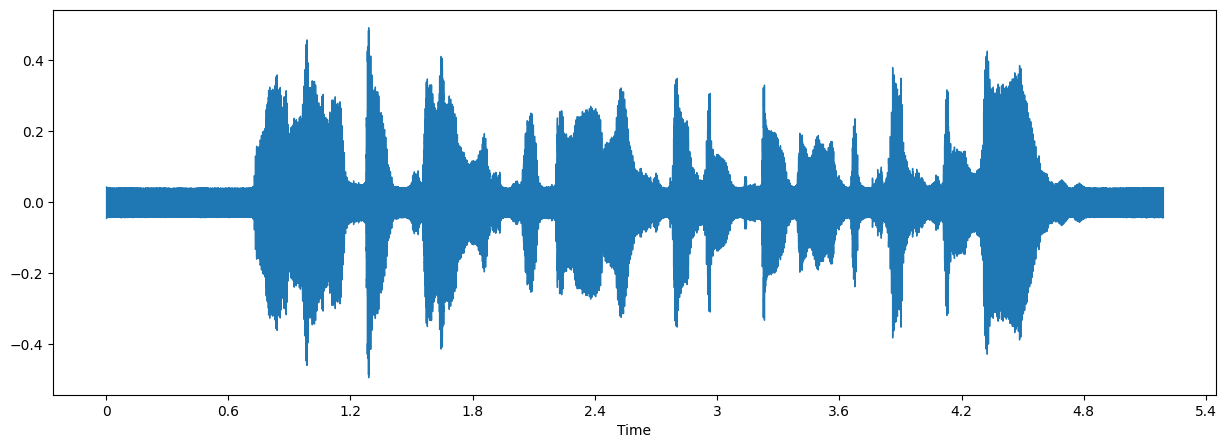

In [16]:
# use the well known Librosa library for this task 
fname = SAVEE + 'DC_sa15.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

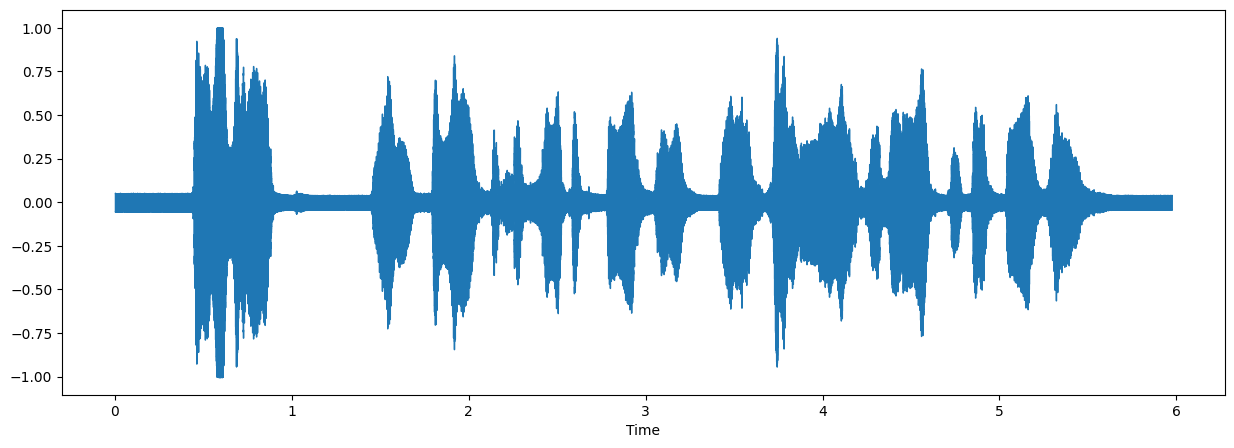

In [14]:
# Lets play a happy track
fname = SAVEE + 'DC_h11.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

### RAVDESS dataset
Here is the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.wav This means the meta data for the audio file is:
- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

Yang harus diperhatikan
- male and female speakers have to be trained seperately or the model will struggle to get a good accuracy
-  female has a higher pitch that male. So if we don't tag the gender label to the audio file, it won't be able to detect anger or fear if it was a male speaker. It will just get bucketed into neutral
- Lets specifically model the 2 speakers seperately. Note that there's a 'calm' emotion and a 'neutral' emotion as seperate. I don't really know the difference but for now, I'll just combined them into the same category.

#### Load Dataset

In [19]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_angry          96
male_happy          96
male_surprise       96
male_fear           96
male_disgust        96
female_happy        96
female_sad          96
female_angry        96
female_disgust      96
female_fear         96
female_surprise     96
Name: labels, dtype: int64

#### Explore Dataset

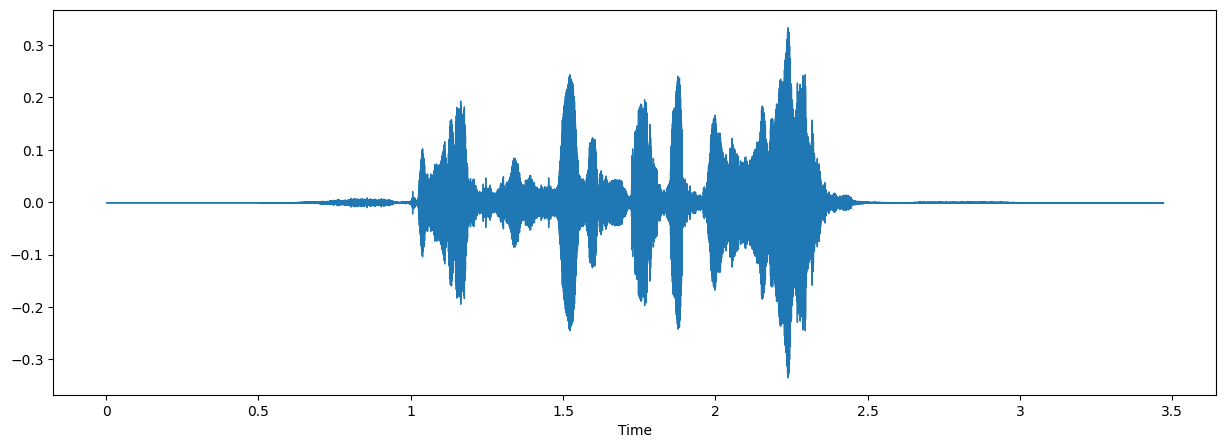

In [22]:
# Pick a fearful track
fname = RAV + 'Actor_14/03-01-06-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

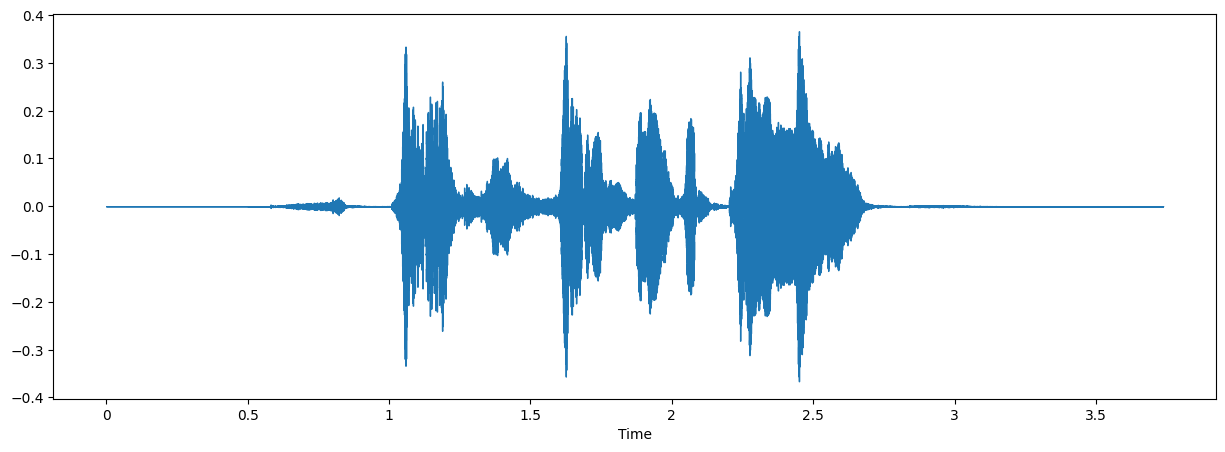

In [21]:
# Pick a happy track
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

I notice the only real difference is the amplitute wherein this happy track has a higher amplituted at various points

### TESS Dataset
Now on to the TESS dataset, its worth nothing that it's only based on 2 speakers, a young female and an older female. This should hopefully balance out the male dominant speakers that we have on SAVEE.

its got the same 7 key emotions we're interested in. But what is slightly different about this dataset compared to the previous two above, is that the addition of 'pleasant surprise' emotion. I haven't really checked to see for the RADVESS and SAVEE dataset, if the surpises are unpleasant. But I'm going to work with the assumption for now that its a pleasant surprise. If we find out from post modelling, surpise is highly inaccurate, we can come back and modify our assumption here.

#### Load Dataset

In [23]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [24]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_fear        400
female_surprise    400
female_sad         400
female_angry       400
female_disgust     400
female_happy       400
female_neutral     400
Name: labels, dtype: int64

#### Explore Data

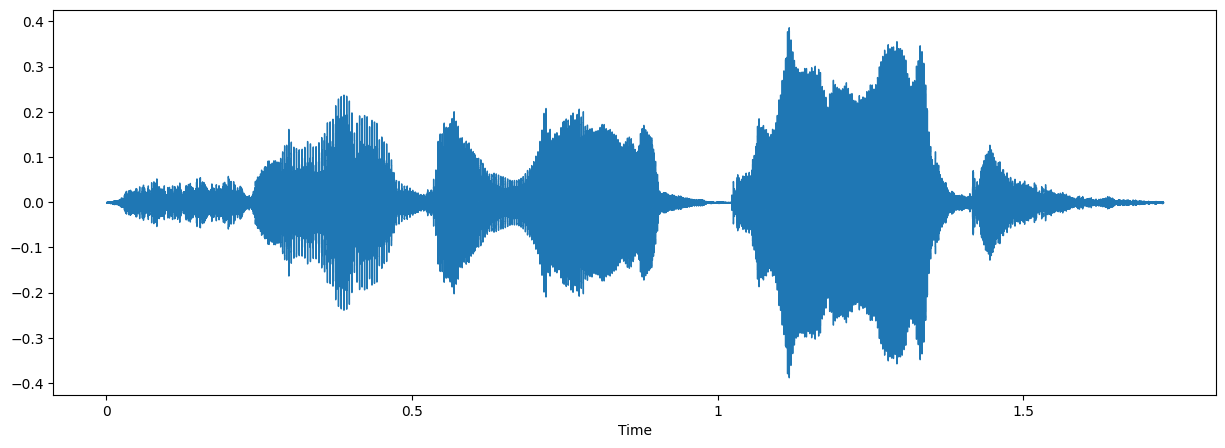

In [26]:
# lets play a fearful track 
fname = TESS + 'YAF_fear/YAF_dog_fear.wav' 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

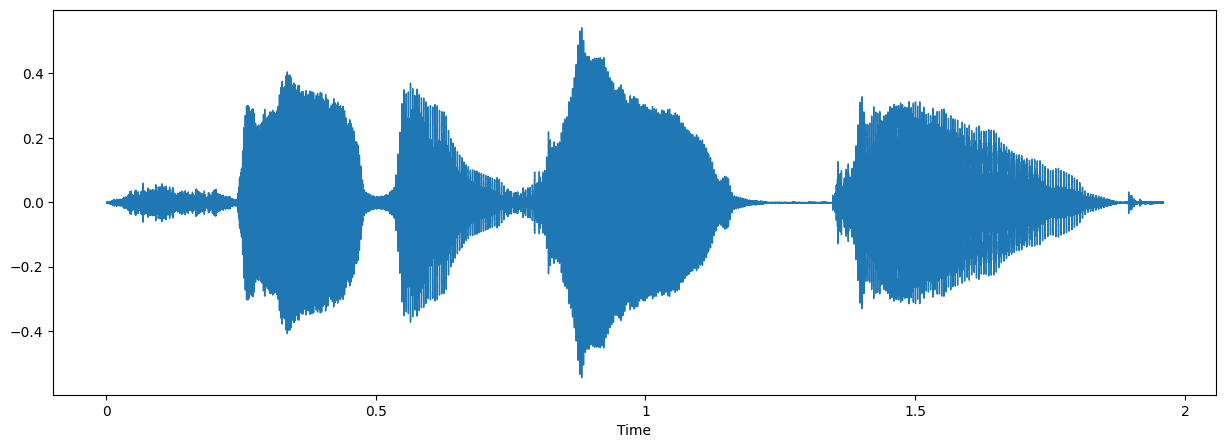

In [27]:
# lets play a happy track 
fname =  TESS + 'YAF_happy/YAF_dog_happy.wav' 

data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

### CREMA-D Dataset
What we are missing from this dataset is the "surprise" emotion but no biggie, we can use the rest. But we have the rest. What's extra here is that it has different level of intensity of the emotion like RAVDESS. But we won't be using that for now

#### Load Dataset

In [28]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [29]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_angry        671
male_disgust      671
male_fear         671
male_happy        671
male_sad          671
female_angry      600
female_disgust    600
female_fear       600
female_happy      600
female_sad        600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

#### Explore Data

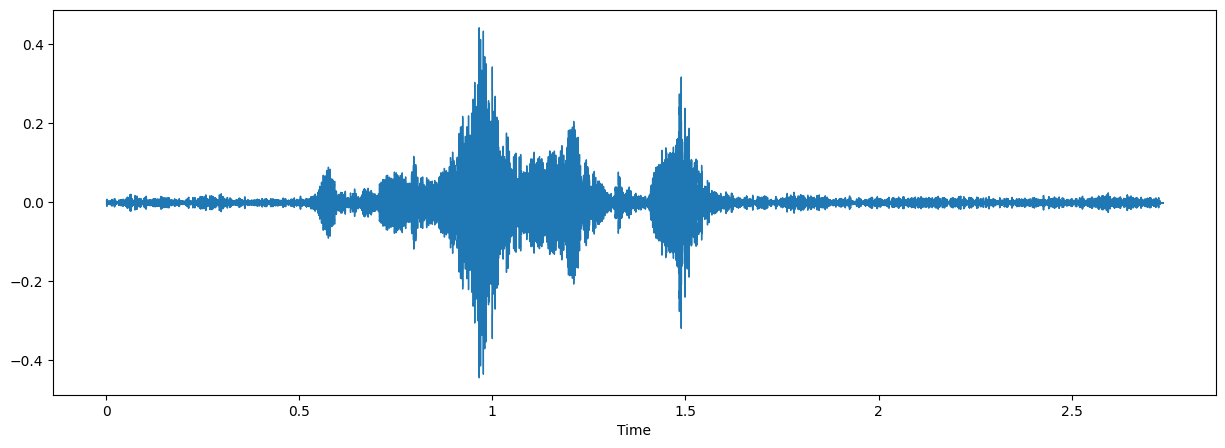

In [31]:
# use the well known Librosa library for this task 
fname = CREMA + '1012_IEO_HAP_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

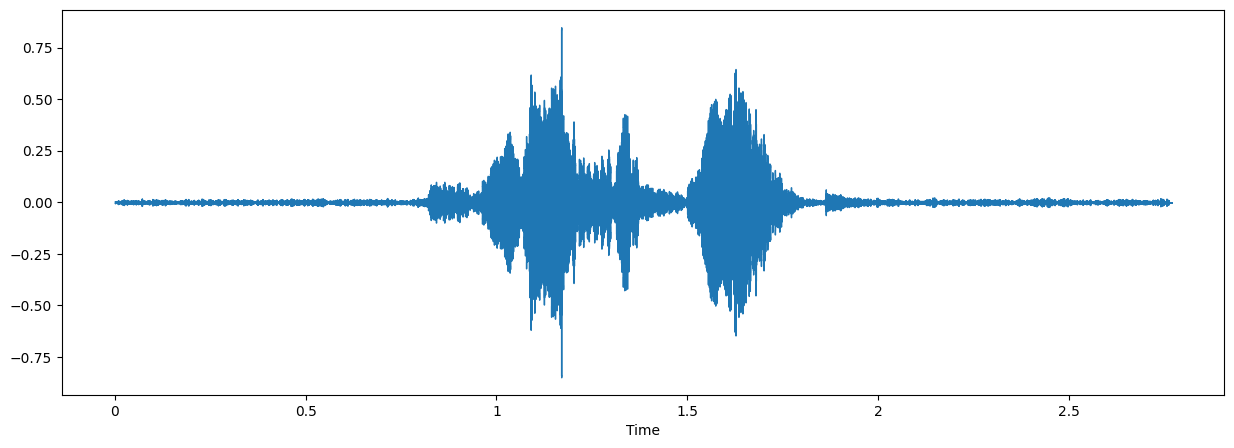

In [32]:
# A fearful track
fname = CREMA + '1012_IEO_FEA_HI.wav'  
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

what I noticed with this CREMA-D dataset is that its is highly varied in its quality. Some are crisp clear and some are really muffled or echoey. Also there's lots of silence as well

## Combine meta-data together as one

In [33]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

female_happy       1096
female_sad         1096
female_angry       1096
female_disgust     1096
female_fear        1096
female_neutral     1056
male_neutral        839
male_angry          827
male_happy          827
male_fear           827
male_disgust        827
male_sad            827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64
